In [1]:
%pylab inline
import pandas as pd
import ldist as ka
import emcee
from scipy.integrate import trapz

Populating the interactive namespace from numpy and matplotlib


In [2]:
### This loads the data and reads it
data = pd.read_csv("data.csv")
dat_m = [float(x) for x in data['Meta'][6:].values if not isnan(float(x))]
dat_m1 = [float(x) for x in data['Meta.1'][6:].values if not isnan(float(x))]
dat_ea = [float(x) for x in data['early Ana'][6:].values if not isnan(float(x))]
dat_a = [float(x) for x in data['Ana'][6:].values if not isnan(float(x))]

In [3]:
#bins the data on grid usefull for comparing with theory
def bindata(data):
    lmax = 1.1*max(data)
    bins = ka.l*lmax
    b = hist(data, bins=bins);
    return b[0]

In [4]:
from scipy.interpolate import interp1d
from scipy.special import factorial

def loglikelihood(args, data, scale, lmin, debug=False):
    """calculates the loglikelihood of the model given the data"""
    a, b, alpha = args  
    a = a/scale
    b = b/scale**2
    p = ka.pdist(a, b, alpha)
    #p = p [ka.l>lmin]
    data = data[(ka.l>lmin)[1:]]
    m = (p[1:] +p[:-1])/2
    m =m[(ka.l>lmin)[1:]]
    m = m/sum(m)*sum(data)
    
    if debug:
        plot(data,'r')
        plot(m,'b')
    
    if min(p) <0:
        if debug: print('ismin')
        return -np.inf
    
    model = log(m**data)-m-log(factorial(data))
    #model = nan_to_num(model)
    out = sum(model)
    if isnan(out):
        if debug: print('isnan')
        return -np.inf
    if a<0 or b<0 or alpha<0:
        return -np.inf
    if alpha>1:
        return -np.inf
    return out

100%|██████████| 100/100 [00:03<00:00, 26.43it/s]


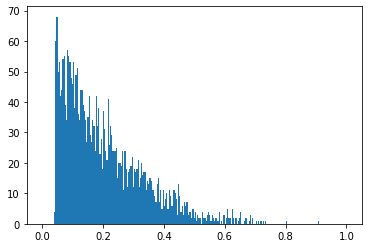

In [5]:
# Setup and prime the MCMC sampler

pool = None

data = dat_a # Choose anaphase dataset ...
lmin = 1500
lmax = 1.1*max(data)
_data = np.array([l for l in data if l>lmin])/lmax
_data = bindata(_data);
lmin = lmin/lmax
lmean = mean(data)
scale = lmean/lmax

sampler = emcee.EnsembleSampler(32,3,loglikelihood, args=(_data, scale, lmin), pool=pool)
sampler.reset()
init = np.array([1,.1,0])[None,:]+0.1*rand(32*3).reshape((32,3))
state = sampler.run_mcmc(init, 100, progress=True)

In [6]:
# Run the MCMC sampler for good
sampler.reset()
o = sampler.run_mcmc(state, 10000, progress=True)

100%|██████████| 10000/10000 [06:47<00:00, 24.51it/s]


In [7]:
# extract result
c = sampler.get_chain(flat=True, discard=100)

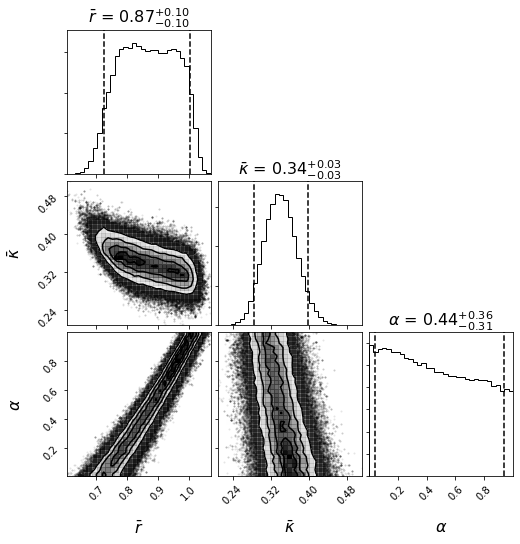

In [8]:
# plot result
import corner
fig = corner.corner(c, 
    labels=['$\\bar r$','$\\bar \\kappa$','$\\alpha$'], label_kwargs={'size':16}
    , show_titles=True, title_kwargs={'size':16} 
    , bins=33
    , reverse = False
    , quantiles = [.05,.95]
);
#savefig(...)


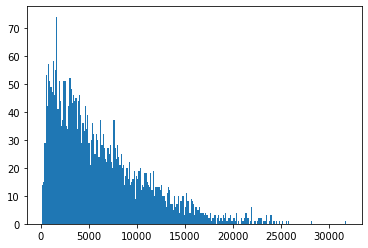

In [9]:
# Get and rescale means and averages
mm = mean(c, axis=0)
vc = sqrt(var(c, axis=0))
mm[0] = mm[0]/scale
mm[1] = mm[1]/scale**2
vc[0] = vc[0]/scale
vc[1] = vc[1]/scale**2
p = ka.pdist(*mm)
b = hist(data, bins=256);

Text(0, 0.5, 'Density')

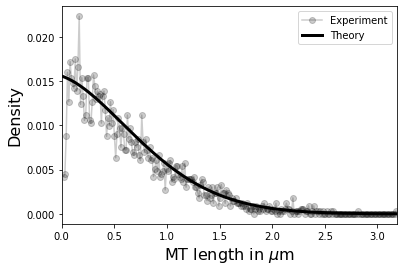

In [10]:
#Plot most likely distribution against data
plot((b[1][1:]+b[1][:-1])/20000,b[0]/sum(b[0])/ka.NL*256, 'o-',
     color='black', alpha=0.2, label='Experiment')
xt = ka.l*lmax/10000
plot(xt, p/sum(p), '-', lw = 3, color='black', label='Theory')
#fill_between(xt,emax1, emin1, alpha=.4, color='grey')

legend()

xlim(0,max(b[1])/10000)
xlabel('MT length in $\\mu$m', size=16)
xlabel('MT length in $\\mu$m',size=16)
ylabel('Density',size=16)
#savefig(...)